## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
#!pip install geopandas

In [2]:
#import geopandas as gpd
import folium 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [3]:
df = pd.read_csv('data/kc_house_data.csv', index_col='id')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  object 
 8   view           21534 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

In [5]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [6]:
for c in df.columns:
    print ("---- %s ---" % c)
    print (df[c].value_counts())
    print("\n")

---- date ---
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
3/8/2015       1
8/30/2014      1
5/27/2015      1
2/15/2015      1
5/15/2015      1
Name: date, Length: 372, dtype: int64


---- price ---
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


---- bedrooms ---
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64


---- bathrooms ---
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6

In [7]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [8]:
#Finding which row contains the 33 bedroom home
#Given the square footage it is safe to assume that this is a typo
df.loc[df['bedrooms'] == 33]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,NO,NONE,Very Good,7 Average,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [9]:
#Fixing the typo and checking to make sure the 33 is now gone
df['bedrooms'].replace(33, 3, inplace=True)
df['bedrooms'].value_counts()

3     9825
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

In [21]:
import geopy
from geopy import distance

In [16]:
downtown = (47.605, -122.3344)

In [17]:
location = list(zip(df.lat, df.long))

In [22]:
def distancer(row):
    coords_1 = downtown
    coords_2 = (row['lat'], row['long'])
    return geopy.distance.distance(coords_1, coords_2).miles

df['distance_from_dt'] = df.apply(distancer, axis=1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,distance_from_dt
id,,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,7.422544
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,8.046186
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,10.329114
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,6.430056
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,13.544634


In [23]:
df['distance_from_dt'].describe()

count    21597.000000
mean        11.512473
std          6.609412
min          0.719565
25%          6.114130
50%         10.350290
75%         15.774479
max         48.161387
Name: distance_from_dt, dtype: float64

In [24]:
#Check for multicollinearity
corr = df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='RdBu', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,distance_from_dt
price,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bedrooms,0.32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bathrooms,0.53,0.53,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_living,0.70,0.59,0.76,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_lot,0.09,0.03,0.09,0.17,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
floors,0.26,0.18,0.50,0.35,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_above,0.61,0.49,0.69,0.88,0.18,0.52,nan,nan,nan,nan,nan,nan,nan,nan,nan
yr_built,0.05,0.16,0.51,0.32,0.05,0.49,0.42,nan,nan,nan,nan,nan,nan,nan,nan
yr_renovated,0.13,0.02,0.05,0.06,0.00,0.00,0.02,-0.23,nan,nan,nan,nan,nan,nan,nan
zipcode,-0.05,-0.16,-0.20,-0.20,-0.13,-0.06,-0.26,-0.35,0.07,nan,nan,nan,nan,nan,nan


In [68]:
#drop multicollinear columns where correlation coefficient is greater than .7
skinnydf = df.drop(columns=['bathrooms', 'sqft_above','sqft_living15','sqft_lot15'])

In [26]:
skinnycorr = skinnydf.corr()
mask = np.zeros_like(skinnycorr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
skinnycorr[mask] = np.nan
(skinnycorr
 .style
 .background_gradient(cmap='RdBu', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,price,bedrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated,zipcode,lat,long,distance_from_dt
price,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bedrooms,0.32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_living,0.70,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_lot,0.09,0.03,0.17,nan,nan,nan,nan,nan,nan,nan,nan
floors,0.26,0.18,0.35,-0.00,nan,nan,nan,nan,nan,nan,nan
yr_built,0.05,0.16,0.32,0.05,0.49,nan,nan,nan,nan,nan,nan
yr_renovated,0.13,0.02,0.06,0.00,0.00,-0.23,nan,nan,nan,nan,nan
zipcode,-0.05,-0.16,-0.20,-0.13,-0.06,-0.35,0.07,nan,nan,nan,nan
lat,0.31,-0.01,0.05,-0.09,0.05,-0.15,0.03,0.27,nan,nan,nan
long,0.02,0.14,0.24,0.23,0.13,0.41,-0.07,-0.56,-0.14,nan,nan


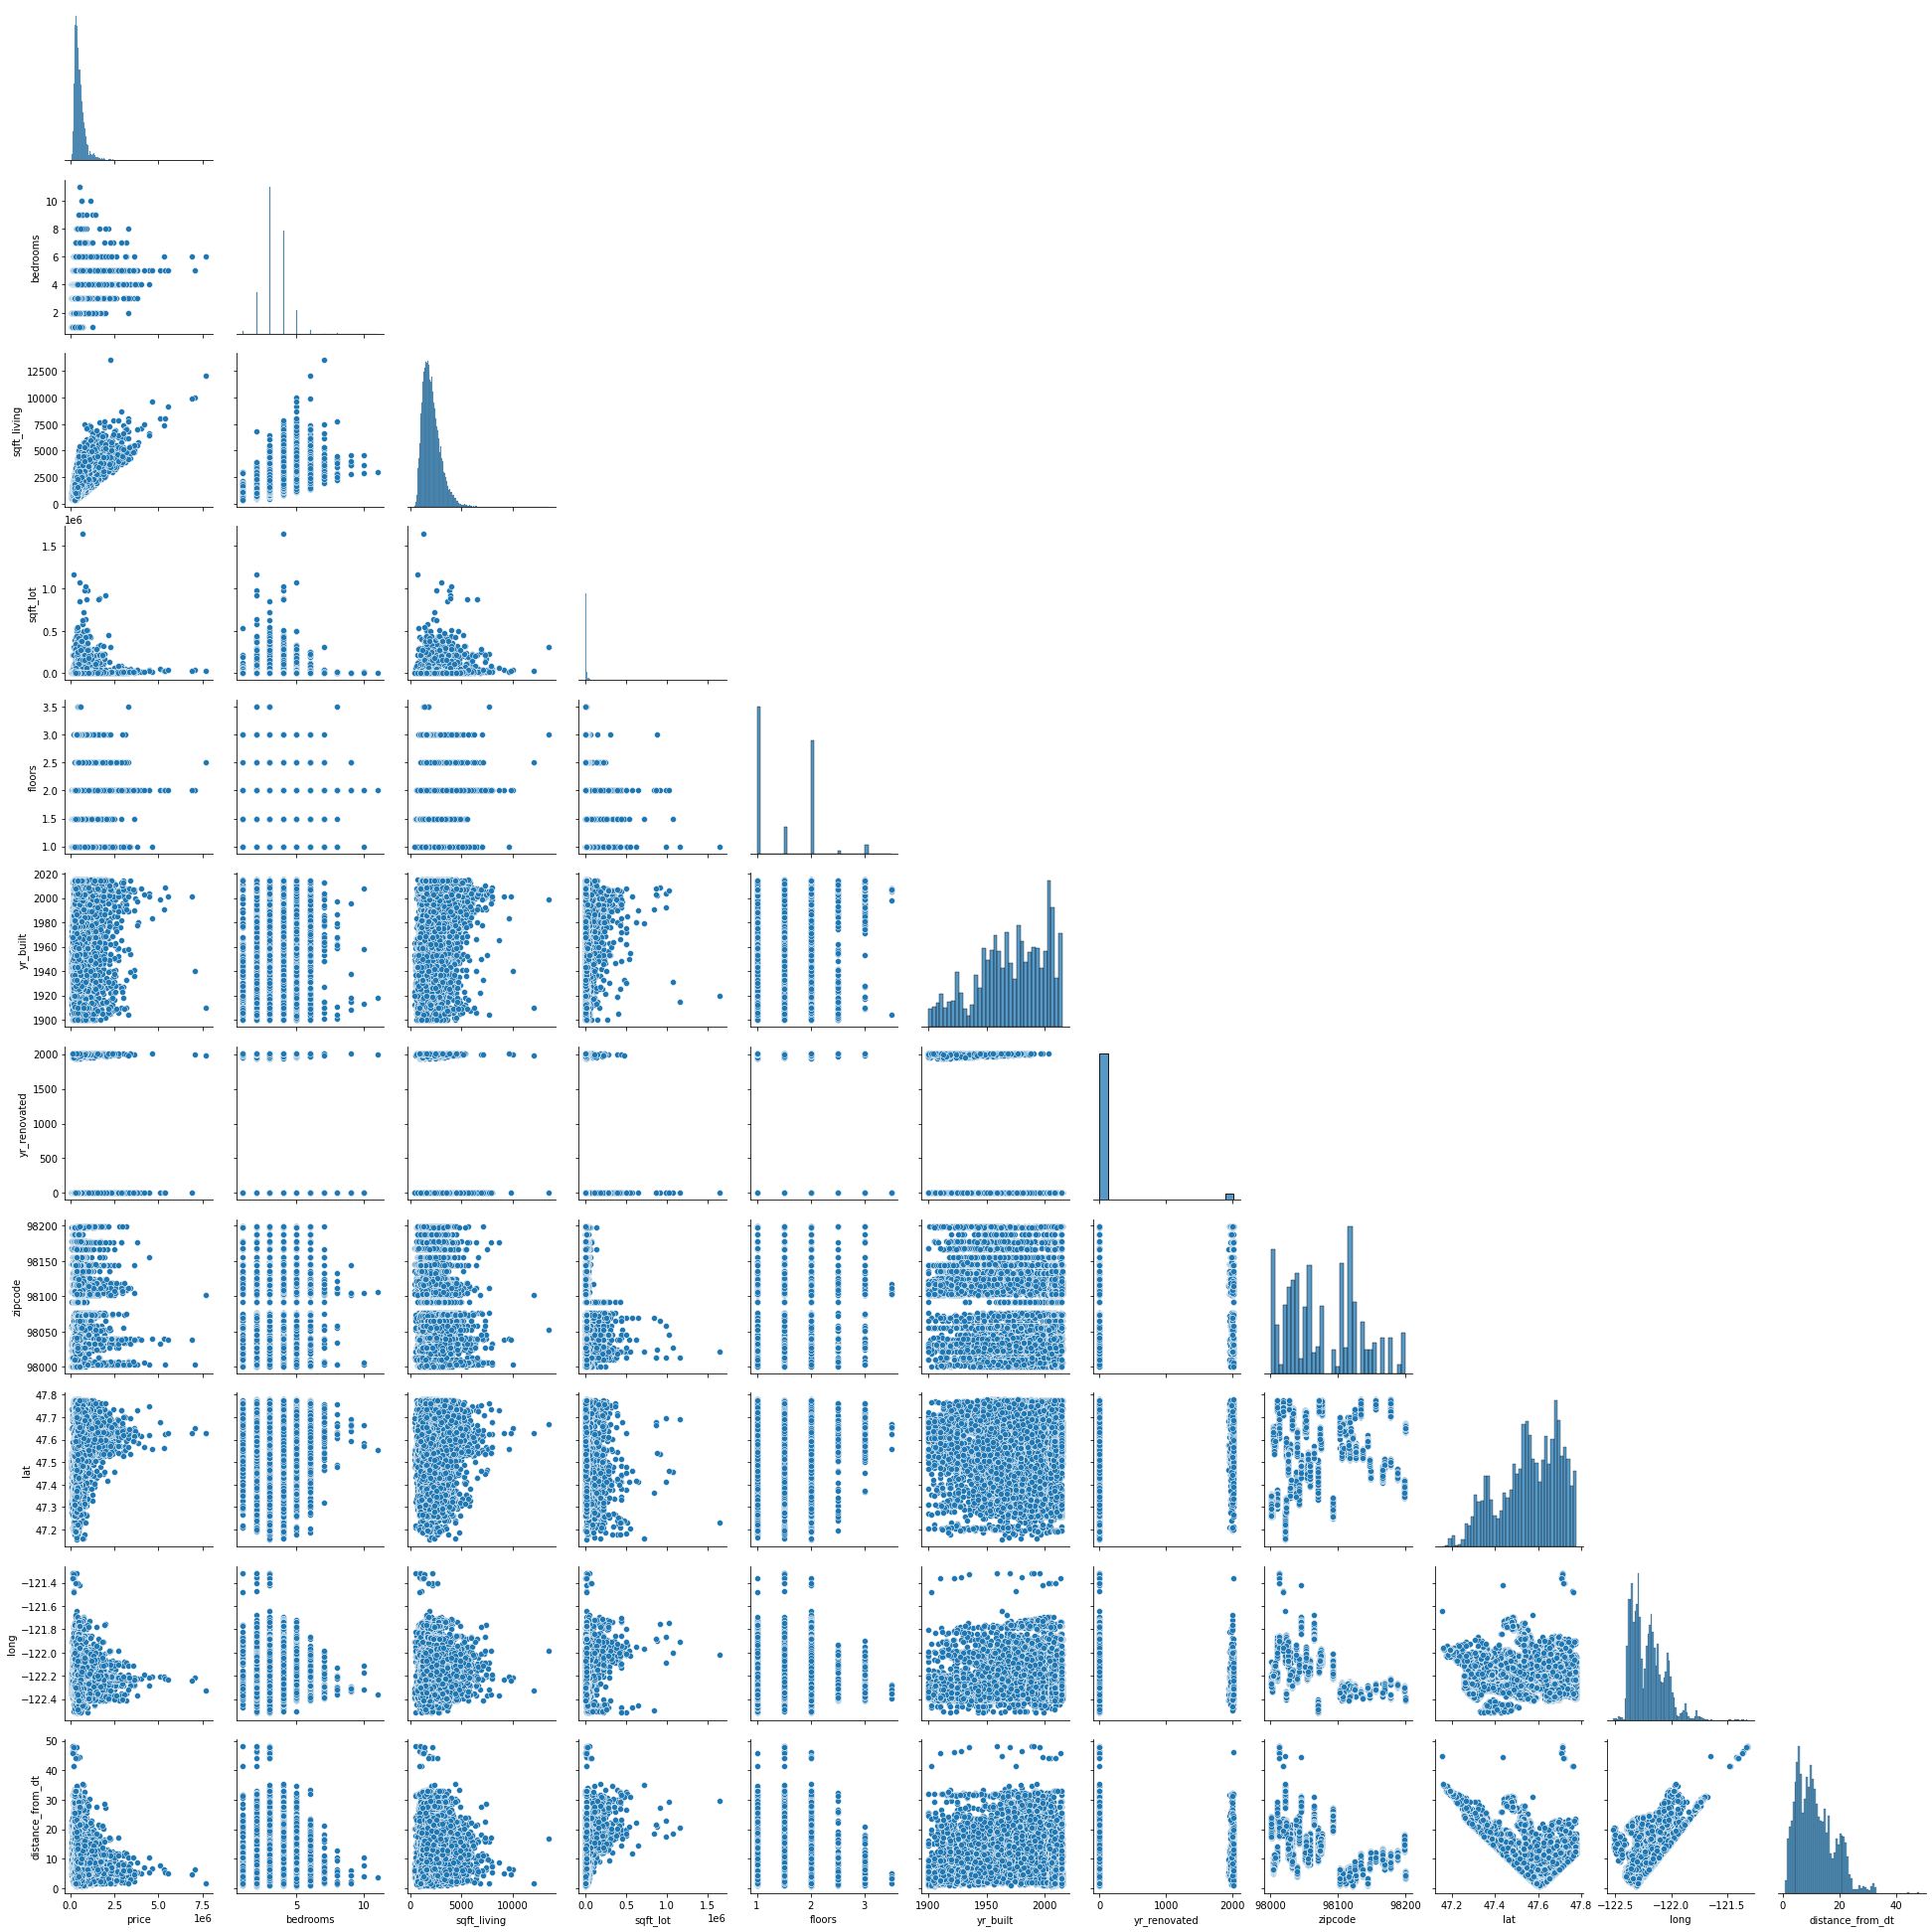

In [27]:
sns.pairplot(skinnydf, corner=True);

In [95]:
simple_formula = 'price ~ distance_from_dt'
simple_model = ols(simple_formula, skinnydf).fit()
simple_model_summary = simple_model.summary()

simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1868.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:25:00   Log-Likelihood:            -3.0650e+05
No. Observations:               21597   AIC:                         6.130e+05
Df Residuals:                   21595   BIC:                         6.130e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         7.208e+05   4817.010    149.643      0.000    7.11e+05     7.3e+05
distance_from_dt -1.568e+04    362.870    -43.215      0.000   -1.64e+04    -1.5e+04
==============================================================================
Omnibus:                    19440.132   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1298050.747
Skew:                           4.094   Prob(JB):                         0.00
Kurtosis:                      40.087   Cond. No.                         26.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

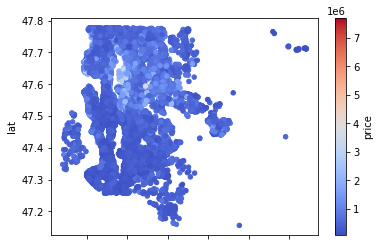

<Figure size 1080x576 with 0 Axes>

In [77]:
skinnydf.plot(x="long", y="lat", kind="scatter", c="price",
        colormap="coolwarm")
plt.figure(figsize = (15,8));

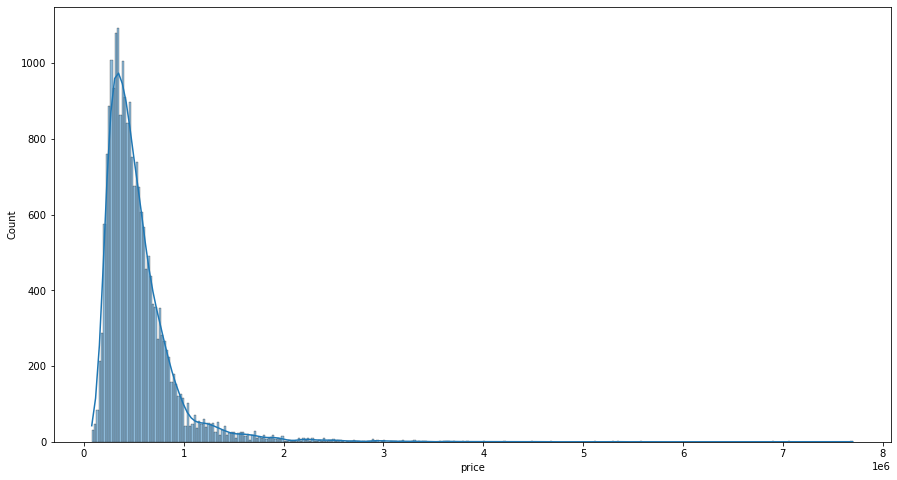

In [29]:
plt.figure(figsize = (15,8))
sns.histplot(skinnydf['price'], kde=True);

In [59]:
skinnydf['price'].describe()

count    2.105300e+04
mean     5.446098e+05
std      3.698417e+05
min      7.800000e+04
25%      3.250000e+05
50%      4.550000e+05
75%      6.500000e+05
max      7.700000e+06
Name: price, dtype: float64

In [90]:
normdf = skinnydf[skinnydf['price'] <= 645000]

In [91]:
normdf['price'].describe()

count     16226.000000
mean     392154.534821
std      126658.383711
min       78000.000000
25%      290000.000000
50%      385000.000000
75%      491837.500000
max      645000.000000
Name: price, dtype: float64

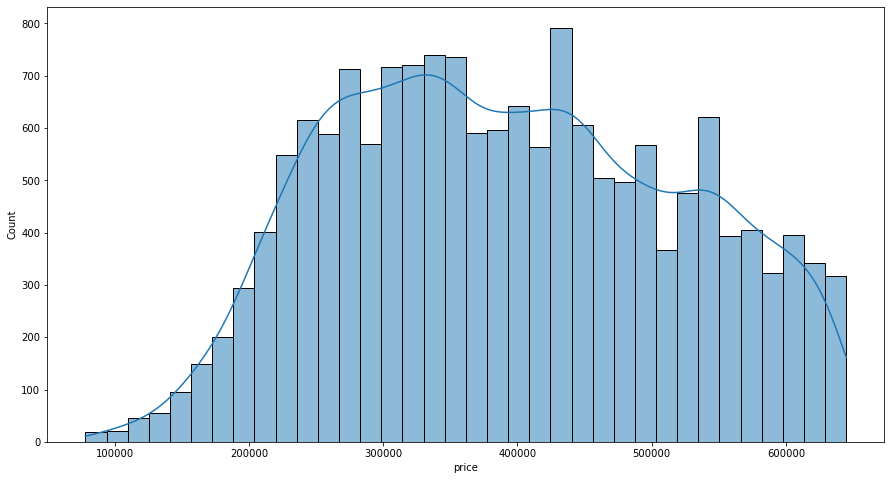

In [81]:
plt.figure(figsize = (15,8))
sns.histplot(normdf['price'], kde=True);

<AxesSubplot:xlabel='distance_from_dt', ylabel='Count'>

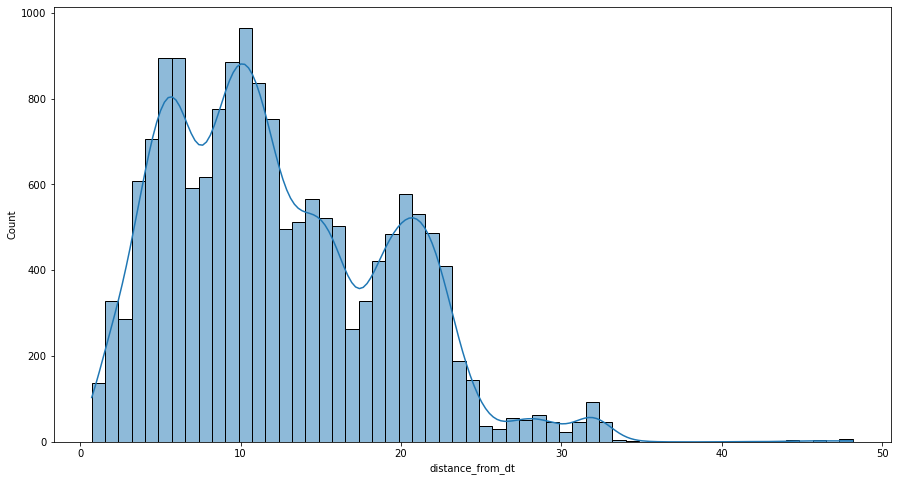

In [46]:
plt.figure(figsize = (15,8))
sns.histplot(skinnydf['distance_from_dt'], kde=True)

In [82]:
normdf = skinnydf[skinnydf['distance_from_dt'] <= 25]

In [83]:
normdf['distance_from_dt'].describe()

count    21053.000000
mean        11.035151
std          5.950376
min          0.719565
25%          6.040218
50%         10.178435
75%         15.201154
max         24.934921
Name: distance_from_dt, dtype: float64

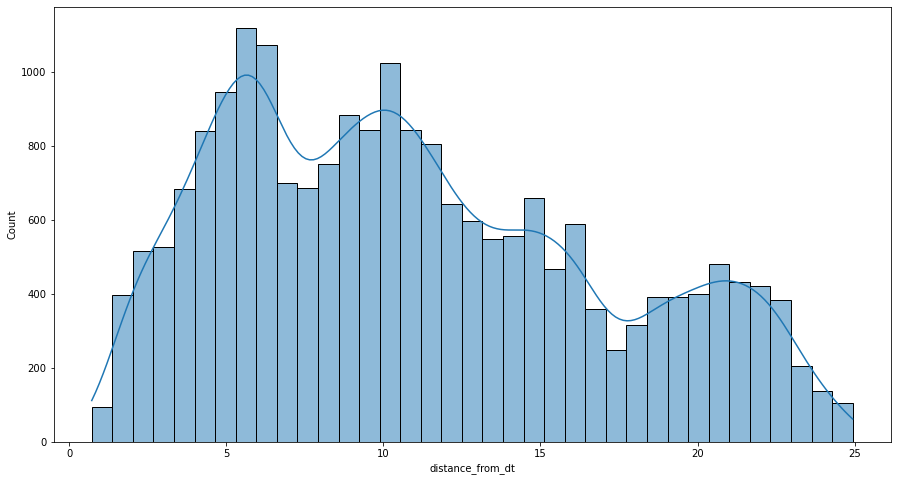

In [84]:
plt.figure(figsize = (15,8))
sns.histplot(normdf['distance_from_dt'], kde=True);

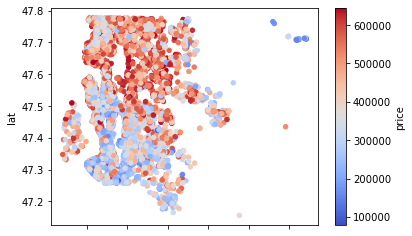

<Figure size 1080x576 with 0 Axes>

In [92]:
normdf.plot(x="long", y="lat", kind="scatter", c="price",
        colormap="coolwarm")
plt.figure(figsize = (15,8));

In [93]:
normdf.describe()

,price,bedrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated,zipcode,lat,long,distance_from_dt
count,16226.000000,16226.000000,16226.000000,1.622600e+04,16226.000000,16226.000000,13336.000000,16226.000000,16226.000000,16226.000000,16226.000000
mean,392154.534821,3.222174,1776.169296,1.302602e+04,1.421669,1970.387341,58.579109,98079.383274,47.540382,-122.217715,12.377544
std,126658.383711,0.856483,633.080993,3.246842e+04,0.533872,28.220381,336.641632,54.138375,0.148736,0.142190,6.803175
min,78000.000000,1.000000,370.000000,5.720000e+02,1.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,0.719565
25%,290000.000000,3.000000,1310.000000,5.000000e+03,1.000000,1952.000000,0.000000,98032.000000,47.423500,-122.331000,6.781221
50%,385000.000000,3.000000,1700.000000,7.450500e+03,1.000000,1972.000000,0.000000,98065.000000,47.540300,-122.251000,11.106605
75%,491837.500000,4.000000,2160.000000,9.949500e+03,2.000000,1994.000000,0.000000,98118.000000,47.681000,-122.135000,17.463461
max,645000.000000,11.000000,5461.000000,1.164794e+06,3.500000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,48.161387


In [87]:
normcorr = normdf.corr()
mask = np.zeros_like(normcorr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
normcorr[mask] = np.nan
(normcorr
 .style
 .background_gradient(cmap='RdBu', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,price,bedrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated,zipcode,lat,long,distance_from_dt
price,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bedrooms,0.32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_living,0.70,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan
sqft_lot,0.10,0.04,0.19,nan,nan,nan,nan,nan,nan,nan,nan
floors,0.25,0.18,0.35,-0.01,nan,nan,nan,nan,nan,nan,nan
yr_built,0.05,0.16,0.32,0.05,0.49,nan,nan,nan,nan,nan,nan
yr_renovated,0.13,0.02,0.06,0.01,0.00,-0.22,nan,nan,nan,nan,nan
zipcode,-0.07,-0.17,-0.21,-0.13,-0.06,-0.35,0.07,nan,nan,nan,nan
lat,0.30,-0.02,0.05,-0.04,0.04,-0.15,0.04,0.24,nan,nan,nan
long,0.05,0.17,0.28,0.22,0.15,0.44,-0.09,-0.57,-0.08,nan,nan


In [89]:
normdf.describe()

,price,bedrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated,zipcode,lat,long,distance_from_dt
count,2.105300e+04,21053.000000,21053.000000,2.105300e+04,21053.000000,21053.000000,17298.000000,21053.000000,21053.000000,21053.000000,21053.000000
mean,5.446098e+05,3.377286,2084.191802,1.377786e+04,1.496271,1970.835178,82.852815,98079.089821,47.565475,-122.222722,11.035151
std,3.698417e+05,0.907885,919.719357,3.482870e+04,0.541217,29.424956,398.165623,53.649115,0.134246,0.129185,5.950376
min,7.800000e+04,1.000000,370.000000,5.200000e+02,1.000000,1900.000000,0.000000,98001.000000,47.257400,-122.519000,0.719565
25%,3.250000e+05,3.000000,1430.000000,5.000000e+03,1.000000,1951.000000,0.000000,98033.000000,47.479300,-122.331000,6.040218
50%,4.550000e+05,3.000000,1920.000000,7.532000e+03,1.500000,1974.000000,0.000000,98072.000000,47.576600,-122.239000,10.178435
75%,6.500000e+05,4.000000,2550.000000,1.048000e+04,2.000000,1997.000000,0.000000,98118.000000,47.679600,-122.135000,15.201154
max,7.700000e+06,11.000000,13540.000000,1.164794e+06,3.500000,2015.000000,2015.000000,98199.000000,47.777600,-121.815000,24.934921


In [96]:
simple_formula = 'price ~ distance_from_dt'
simple_model = ols(simple_formula, normdf).fit()
simple_model_summary = simple_model.summary()

simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     1552.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):          4.94e-324
Time:                        17:25:19   Log-Likelihood:            -2.1293e+05
No. Observations:               16226   AIC:                         4.259e+05
Df Residuals:                   16224   BIC:                         4.259e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4.602e+05   1972.259    233.355      0.000    4.56e+05    4.64e+05
distance_from_dt -5500.5002    139.640    -39.391      0.000   -5774.210   -5226.790
==============================================================================
Omnibus:                      710.670   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.713
Skew:                           0.112   Prob(JB):                     2.28e-70
Kurtosis:                       2.348   Cond. No.                         29.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
simple_formula = 'price ~ sqft_living'
simple_model = ols(simple_formula, normdf).fit()
simple_model_summary = simple_model.summary()

simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     3929.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:25:53   Log-Likelihood:            -2.1191e+05
No. Observations:               16226   AIC:                         4.238e+05
Df Residuals:                   16224   BIC:                         4.238e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.353e+05   2657.434     88.529      0.000     2.3e+05     2.4e+05
sqft_living    88.3338      1.409     62.678      0.000      85.571      91.096
==============================================================================
Omnibus:                     1706.164   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              623.731
Skew:                           0.246   Prob(JB):                    3.62e-136
Kurtosis:                       2.175   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
simple_formula = 'price ~ sqft_living + distance_from_dt'
simple_model = ols(simple_formula, normdf).fit()
simple_model_summary = simple_model.summary()

simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     4912.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:26:25   Log-Likelihood:            -2.0983e+05
No. Observations:               16226   AIC:                         4.197e+05
Df Residuals:                   16223   BIC:                         4.197e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.958e+05   2497.221    118.451      0.000    2.91e+05    3.01e+05
sqft_living        111.6601      1.285     86.891      0.000     109.141     114.179
distance_from_dt -8238.2984    119.583    -68.892      0.000   -8472.695   -8003.902
==============================================================================
Omnibus:                      224.379   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.320
Skew:                           0.130   Prob(JB):                     6.89e-35
Kurtosis:                       2.593   Cond. No.                     6.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""